In [46]:
# US stock prediction

ライブラリ

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

# 必要情報の入力
start = '2021-01-04'
end = '2024-02-01'
tickers = 'TSLA'  # 予測対象の株価シンボル
seq_length = 30 #周期性がどの程度あるのか？ここをよく見ながら設定すること！！
num_test = 2 # 予測日数
hidden_size = 300 # 隠れ層数の設定
num_epochs = 200 # エポック数の設定


# 株価データの取得
ori_y = yf.download(tickers, start=start, end=end)["Close"]

# データの正規化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(ori_y.values.reshape(-1, 1))

# ランダムシードの固定化
seed_value = 42
np.random.seed(seed_value)

plt.style.use("ggplot")
%matplotlib inline

print(f"start:{start} end:{end} ticker:{tickers}")
print(scaled_data.size)


[*********************100%%**********************]  1 of 1 completed

start:2021-01-04 end:2024-02-01 ticker:TSLA
774


教師データ

In [48]:
y = scaled_data
y = y.squeeze()
allsize = y.shape[0]
print(allsize)
x = np.linspace(0,allsize-1,allsize)
print(y.shape)
print(y.shape)

774
(774,)
(774,)


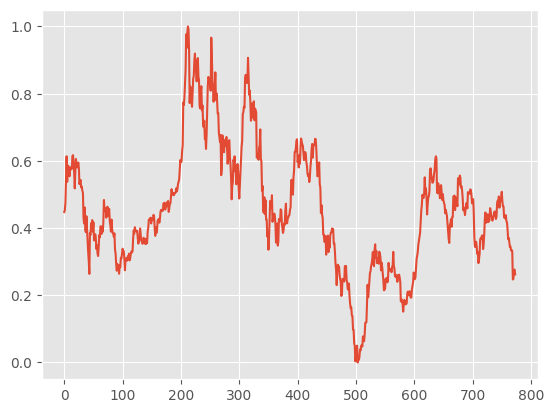

In [49]:
plt.plot(x,y)

窓スライド処理

In [50]:
def make_sequence_data(y, num_sequence):
  num_data = len(y)
  seq_data = [] # 4つ刻みのデータを格納する用のリスト
  target_data = [] # seq_dataの1つ次のデータを格納する用のリスト
  for i in range(num_data - num_sequence):
    seq_data.append(y[i : i + num_sequence])
    target_data.append(y[i+num_sequence : i + num_sequence + 1])
  seq_arr = np.array(seq_data)
  target_arr = np.array(target_data)
  #return seq_arr, target_arr
  return seq_arr.squeeze(), target_arr.squeeze()

In [51]:
y_seq, y_target = make_sequence_data(y , seq_length)

In [52]:
y_seq_train = y_seq[:-num_test]
y_seq_test = y_seq[-num_test:]
y_target_train = y_target[:-num_test]
y_target_test = y_target[-num_test:]

In [53]:
y_seq_train.shape

(742, 30)

pytorch用の処理

In [54]:
# tensorに変換する
y_seq_t = torch.FloatTensor(y_seq_train)
y_target_t = torch.FloatTensor(y_target_train)

In [55]:
y_target_t.shape
#y_seq_t.shape

torch.Size([742])

LSTMの定義
 #x_last=x[-1]は予測したラストを抽出

In [56]:
class LSTM(nn.Module):
  def __init__(self, hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size = 1,hidden_size = self.hidden_size)
    self.linear = nn.Linear(self.hidden_size,1)

  def forward(self,x):
    x, _ =self.lstm(x)
    x_last = x[-1]
    x = self.linear(x_last)
    return x

In [57]:
model = LSTM(hidden_size)

Loss関数と最適化アルゴの定義

In [58]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

LSTMに入力するための処理

In [59]:
# LSTMにインプットする際に先にシーケンス上の軸が来て、つぎにバッチサイズが来る、最後にインプットサイズの軸が来る
# y_seq_tの順番が逆であるので入れ替える必要がある

In [60]:
y_seq_t = y_seq_t.permute(1,0)

In [61]:
# 40×450の2次元テンサーなので、1次元にする必要がる
 # unsqueezeはsqueezeの反対なのでsqueezeは40x450x1を絞って40x450にするがunsqueezeは次元を広げる働きがある。dim=-1にすると最後の列に1を付与できる

In [62]:
y_seq_t = y_seq_t.unsqueeze(dim=-1)
y_target_t = y_target_t.unsqueeze(dim=-1)

In [63]:
y_seq_t.shape

torch.Size([30, 742, 1])

学習トレーニング
ミニバッチのランニングLossを初期化することが通常だが
今回はバッチ学習のためいきなりOptimizerの初期化を実施します

In [64]:

losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(y_seq_t)
    loss = criterion(output, y_target_t)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    if epoch % 10 == 0:
        print("epoch: {}, loss: {}".format(epoch, loss.item()))

epoch: 0, loss: 0.22602081298828125
epoch: 10, loss: 0.026334794238209724
epoch: 20, loss: 0.022277601063251495
epoch: 30, loss: 0.018862171098589897
epoch: 40, loss: 0.010286608710885048
epoch: 50, loss: 0.005856902338564396
epoch: 60, loss: 0.004251100122928619
epoch: 70, loss: 0.003449435578659177
epoch: 80, loss: 0.0030655083246529102
epoch: 90, loss: 0.002805297262966633
epoch: 100, loss: 0.0026207927148789167
epoch: 110, loss: 0.0025015370920300484
epoch: 120, loss: 0.0024148104712367058
epoch: 130, loss: 0.0023363337386399508
epoch: 140, loss: 0.002266892697662115
epoch: 150, loss: 0.0022066538222134113
epoch: 160, loss: 0.0021546727512031794
epoch: 170, loss: 0.0021072530653327703
epoch: 180, loss: 0.0020614713430404663
epoch: 190, loss: 0.0020174228120595217


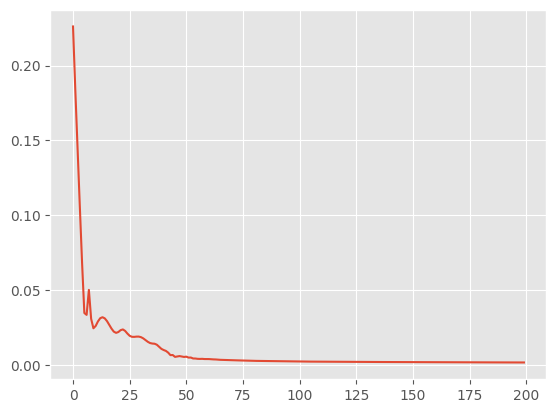

In [65]:
plt.plot(losses)

In [66]:
y_seq_test_t = torch.FloatTensor(y_seq_test)
y_seq_test_t = y_seq_test_t.permute(1,0)
y_seq_test_t = y_seq_test_t.unsqueeze(dim=-1)

In [67]:
y_seq_test_t.size()

torch.Size([30, 2, 1])

In [68]:
#print(y_seq_test_t)

In [69]:
y_pred = model(y_seq_test_t)

(754.0, 776.0)

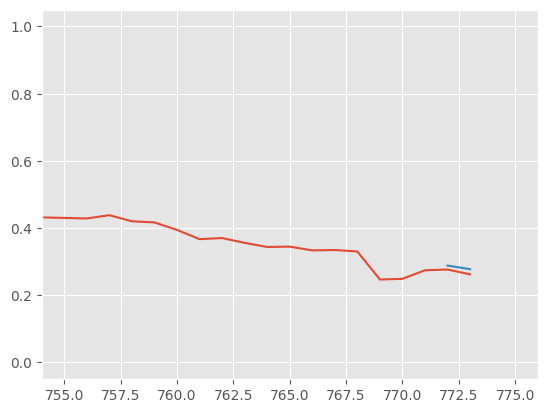

In [70]:
plt.plot(x,y)
plt.plot(np.arange(allsize-num_test,allsize),y_pred.detach())
plt.xlim([allsize-num_test*10,allsize+num_test])

### 未知データ予測
pred_daysに与える日数分を予測する

In [71]:
scaled_data = scaler.fit_transform(ori_y.values.reshape(-1, 1))

# prediction loop
pred_days=30
#maxnum=len(scaled_data)
ii=0
jj=0
kk=0
#yy=[]
for kk in range(pred_days):
  yy=[]
  for ii in range(seq_length):
    for jj in range(num_test):
      yy_value = float(scaled_data[ii+jj-seq_length-num_test+1])
      yy.append(yy_value)
      if(ii==29):
          print(f"count:{ii+jj-seq_length-num_test+2} {yy}")
      jj+=1
  #print(yy)
  # yyをtorch.Tensorに変換
  yy_tensor = torch.tensor(yy)
  yy_tensor_reshaped = yy_tensor.view(seq_length,num_test)
  yy_tensor_reshaped = yy_tensor_reshaped.unsqueeze(dim=-1)
  #print(yy_tensor_reshaped)
  #print(yy_tensor_reshaped.size())
  # prediction
  y_pred2 = model(yy_tensor_reshaped)
  print(f"prediction:{y_pred2[-1]}")
  # y_pred2[-1]をscaled_dataの末尾に付与
  scaled_data_tensor = torch.tensor(scaled_data)
  scaled_data = torch.cat((scaled_data_tensor, y_pred2[-1].unsqueeze(0)), dim=0)
#print(scaled_data)

print(scaled_data.size())
# 結果を表示
#print(scaled_data[-10:])
#print(y_pred2)


<ipython-input-71-de13c9266753>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yy_value = float(scaled_data[ii+jj-seq_length-num_test+1])
<ipython-input-71-de13c9266753>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scaled_data_tensor = torch.tensor(scaled_data)


count:-1 [0.4816642932485785, 0.4769602876964356, 0.4769602876964356, 0.4939874826574515, 0.4939874826574515, 0.46059561947349414, 0.46059561947349414, 0.48497697748650026, 0.48497697748650026, 0.47848409413925164, 0.47848409413925164, 0.4919666927028672, 0.4919666927028672, 0.5079670141852853, 0.5079670141852853, 0.4806042100296196, 0.4806042100296196, 0.46503460422089726, 0.46503460422089726, 0.46483585125423, 0.46483585125423, 0.4318083853583461, 0.4318083853583461, 0.43008577540131276, 0.43008577540131276, 0.42862823679656925, 0.42862823679656925, 0.4384337538341896, 0.4384337538341896, 0.42024714971843113, 0.42024714971843113, 0.416868197642437, 0.416868197642437, 0.39460695551979874, 0.39460695551979874, 0.36701228975220457, 0.36701228975220457, 0.3703912418281987, 0.3703912418281987, 0.35594793652895784, 0.35594793652895784, 0.34379039144149104, 0.34379039144149104, 0.3448173154676387, 0.3448173154676387, 0.333587317922986, 0.333587317922986, 0.3347136184324674, 0.33471361843246

# 推論結果を保存する

In [72]:
# 推論時の結果保存
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')
y_predout=scaled_data.detach().numpy()
y_predout2 = pd.DataFrame(y_predout)
y_predout2.to_csv("/content/gdrive/MyDrive/output/pred_30days_0304.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


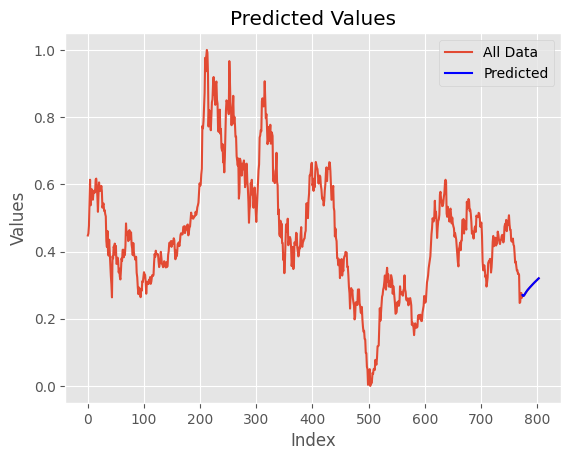

In [73]:
# pred_daysの日数に対応する部分を抽出
pred_data = y_predout2.iloc[-pred_days:]

# 全体をプロット
plt.plot(y_predout2, label='All Data')

# pred_daysの日数に対応する部分を別の色でプロット
plt.plot(pred_data, label='Predicted', color='blue')

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Predicted Values')
plt.legend()
plt.show()